In [1]:
#@title dependencies
!pip install magpylib
!pip install numpy
!pip install matplotlib

from numpy import array, round, zeros, pi, linalg, savetxt, vstack, hstack, linspace
from matplotlib.pyplot import figure, tight_layout, figure, show, rcParams
from mpl_toolkits.mplot3d import axes3d
from datetime import datetime
from os import mkdir
from magpylib.source.magnet import Cylinder
from magpylib import Collection, displaySystem

In [2]:
#@title calculation_functions

# calculation functions

def normalize(vector):
    """
    -----------
    DESCRIPTION
    -----------

    Transforms a vector into unitary

    ----------
    PARAMETERS
    ----------

    :param vector: numpy.array | input vector, any dimension
    :return: numpy.array | output vector, same dimension as input but norm 1

    -------
    EXAMPLE
    -------
    >>> from numpy import arrray

    >>> vector3d = array([0,0,2])

    >>> normalize(vector3d)
    array([0., 0., 1.])

    >>> vector2d = array([1,1])

    >>> normalize(vector2d)
    array([0.70710678, 0.70710678])
    """
    norm = linalg.norm(vector)

    if norm != 0:
        return vector/norm
    else:
        return array(vector)


def jac(foo, x, y, z):
    """
    -----------
    DESCRIPTION
    -----------

    From a point xyz and function returns a 3x3 jacobian matrix of that function on that point
    works with 6 auxiliar points, in x,y,z +- infinitesimal
    function foo takes as argument a 1d array like [x, y, z] and returns

    jac uses central difference derivatives

    ----------
    PARAMETERS
    ----------

    :param foo: function | needs to return
    :param x: float
    :param y: float
    :param z: float
    :return: 3x3 array like
                [[dUdx, dUdy, dUdz]
                [dVdx, dVdy, dVdz]
                [dWdx, dWdy, dWdz]]

    -------
    EXAMPLE
    -------

    >>> def foo(point):
    ...     x, y, z = point
    ...     u = x*y*z
    ...     v = y**2 - x**2
    ...     w = z**2 - x*y
    ...     result = (u, v, w)
    ...     return result
    ...

    >>> foo([1,-2,3])
    (-6, 3, 11)

    >>> jac(foo,1,-2,3)
    array([[-6.,  3., -2.],
           [-2., -4.,  0.],
           [ 2., -1.,  6.]])
    """

    delta = 0.0000001                            # infinitesimal

    fxm = foo([x - delta, y, z])                 # point x - delta
    fxp = foo([x + delta, y, z])                 # point x + delta
    fym = foo([x, y - delta, z])                 # point y - delta
    fyp = foo([x, y + delta, z])                 # point y + delta
    fzm = foo([x, y, z - delta])                 # point z - delta
    fzp = foo([x, y, z + delta])                 # point z + delta

    # derivative using central difference formula

    dd = zeros((3, 3))                           # creation of 3x3 matrix of zeros, to have values replaced

    double_delta = 2 * delta

    dd[0, 0] = (fxp[0] - fxm[0]) / double_delta  # dUdx
    dd[1, 0] = (fxp[1] - fxm[1]) / double_delta  # dVdx
    dd[2, 0] = (fxp[2] - fxm[2]) / double_delta  # dWdx

    dd[0, 1] = (fyp[0] - fym[0]) / double_delta  # dUdy
    dd[1, 1] = (fyp[1] - fym[1]) / double_delta  # dVdy
    dd[2, 1] = (fyp[2] - fym[2]) / double_delta  # dWdy

    dd[0, 2] = (fzp[0] - fzm[0]) / double_delta  # dUdz
    dd[1, 2] = (fzp[1] - fzm[1]) / double_delta  # dVdz
    dd[2, 2] = (fzp[2] - fzm[2]) / double_delta  # dWdz

    dd = round(dd, 5)                            # rounding result

    return dd


def getM(point, collection, sample):
    """
    -----------
    DESCRIPTION
    -----------

    Gets the magnetization of a sample if it would to be put on the point point around a collection of magnets

    ----------
    PARAMETERS
    ----------

    :param point: numpy.array [mm]
    :param collection: magpylib.Collection
    :param sample: dictionary with 'demagnetizing_factor', 'volume' and 'M_saturation' keys, respectively in [], [m3], [A/m]
    :return: numpy.array [A/m]

    -------
    EXAMPLE
    -------

    >>> from setup_magnet_sample.setup_magnet_sample_example import sample, my_collection

    >>> point=(0,0,1)

    >>> getM(point,my_collection,sample)

    >>> array([     0.        ,      0.        , 741977.47732813])

    """
    mu0 = 4*pi*(10**(-7))                      # vacuum permeability in H/m

    n = sample['demagnetizing_factor']         # demagnetizing factor
    M_saturation = sample['M_saturation']      # Ms in A/m

    B = collection.getB(point) / 1000          # magpylib getB returns B in mT, /1000 for T

    H = B / mu0                                # transform B[T] in H[A/m]
    M = H / n                                  # simplification for getting M out of H in ferromagnetic

    if linalg.norm(M) > M_saturation:          # check if M surpasses the saturation
        M = normalize(M) * M_saturation

    return M                                   # returns (Mx, My, Mz) in [A/m]


def getF(point, collection, sample):
    """
    -----------
    DESCRIPTION
    -----------

    Gets the magnetic force in a point xyz given in mm for a ferromagnetic sphere

    ----------
    PARAMETERS
    ----------

    :param point: numpy.array
    :param collection: magpylib.Collection
    :param sample: dictionary with 'demagnetizing_factor', 'volume' and 'M_saturation' keys, respectively in [], [m3], [A/m]
    :return: numpy.array [N]

    -------
    EXAMPLE
    -------

    >>> from setup_magnet_sample.setup_magnet_sample_example import sample, my_collection

    >>> point=(0,0,1)

    >>> getF(point,my_collection,sample)

    >>> array([ 0.        ,  0.        , -0.49650668])
    """
    x, y, z = point

    V = sample['volume']                           # sample volume [m3]

    Mx, My, Mz = getM(point, collection, sample)   # sample magnetization [A/m]

    dd = jac(collection.getB, x, y, z)             # jacobian of B field in given point

    dUdx = dd[0, 0]
    dUdy = dd[0, 1]
    dUdz = dd[0, 2]

    dVdx = dd[1, 0]
    dVdy = dd[1, 1]
    dVdz = dd[1, 2]

    dWdx = dd[2, 0]
    dWdy = dd[2, 1]
    dWdz = dd[2, 2]

    Fx = Mx * dUdx + My * dVdx + Mz * dWdx
    Fy = Mx * dUdy + My * dVdy + Mz * dWdy
    Fz = Mx * dUdz + My * dVdz + Mz * dWdz

    result = round(array([Fx, Fy, Fz]) * V, 10)

    return result                                 # returns (Fx, Fy, Fz) in N


In [3]:
#@title plotting_functions

# make figures bigger on notebook
width = 15
height = 5
rcParams['figure.figsize'] = [width, height]

# functions for plotting 1D

def plot_1D_along_x(xs=array([]), y=0, z=0, collection=None, sample=None, BF='BF', saveCSV=False):
    """
    -----------
    DESCRIPTION
    -----------

    Plots Bx, By, Bz and Fx, Fy, Fz generated by a collection of magnets into a ferromagnetic sample.
    Those variables are plotted along the x direction

    ----------
    PARAMETERS
    ----------

    :param xs: numpy.array | contains the x direction values where the variables are evaluated [mm]
    :param y: float | can be an float or str for y direction, like 'z' [mm]
    :param z: float | can be an float or str for z direction, like 'y' [mm]
    :param collection: magpylib.Collectoin | the magnets setup
    :param sample: Sample | Instance of Sample class; needed if BF contains 'F'
    :param BF: str | 'B' to plot Bx, By, Bz; 'F' to plot Fx, Fy, Fz; 'BF' for all
    :param saveCSV: bool | True for saving a CSV file with the data generated by the function
    :return: plots matplotlib graphs. show() needs to be called manually

    -------
    EXAMPLE
    -------

    >>> # imports
    >>> from numpy import linspace
    >>> from matplotlib.pyplot import show
    >>> from setup_magnet_sample.setup_magnet_sample_example import sample, my_collection
    >>> import project_helpers.plotting_functions as pf
    >>> # creation of space
    >>> xs = linspace(-30, 30, 1000)
    >>> y, z = (0, 0)
    >>> # plotting B and F along x with y=0; z=0
    >>> pf.plot_1D_along_x(xs, y, z, my_collection, sample=sample, BF='BF')
    >>> # plotting B along x with y=z; z=0
    >>> pf.plot_1D_along_x(xs, 'z', z, my_collection, BF='B')
    """

    # generate points for B and F calculation
    POS = array([(x, eval(str(y)), eval(str(z))) for x in xs])

    # pass BF to uppercase to avoid BF='bf' not returning anything
    BF = BF.upper()

    # if user wants plotting of B
    if 'B' in BF:
        # calculate B in mT
        Bfield = array([collection.getB(pos) for pos in POS])

        # split B into lists of Bx, By and Bz
        Bfieldx = Bfield[:, 0]
        Bfieldy = Bfield[:, 1]
        Bfieldz = Bfield[:, 2]

        # create figure to host 4 plots in 2x2 disposition
        fig_B = figure(num=f'''B for y = {y}, z = {z}''')

        # plot Bx along x
        ax_Bx = fig_B.add_subplot(221, title=f'''Bx along x axis, y = {y}, z = {z}''')
        ax_Bx.plot(xs, Bfieldx, 'r')
        ax_Bx.set_xlabel('x [mm]')
        ax_Bx.set_ylabel('Bx [mT]')

        # plot By along x
        ax_By = fig_B.add_subplot(222, title=f'''By along x axis, y = {y}, z = {z}''')
        ax_By.plot(xs, Bfieldy, 'g')
        ax_By.set_xlabel('x [mm]')
        ax_By.set_ylabel('By [mT]')

        # plot Bz along x
        ax_Bz = fig_B.add_subplot(223, title=f'''Bz along x axis, y = {y}, z = {z}''')
        ax_Bz.plot(xs, Bfieldz, 'b')
        ax_Bz.set_xlabel('x [mm]')
        ax_Bz.set_ylabel('Bz [mT]')

        # joins Bx, By and Bz along x in one plot
        ax_B_all = fig_B.add_subplot(224, title=f'''B field along x axis, y = {y}, z = {z}''')
        ax_B_all.plot(xs, Bfieldx, 'r', label='Bx')
        ax_B_all.plot(xs, Bfieldy, 'g', label='By')
        ax_B_all.plot(xs, Bfieldz, 'b', label='Bz')
        ax_B_all.set_xlabel('x [mm]')
        ax_B_all.set_ylabel('B [mT]')

        ax_B_all.legend()
        tight_layout()

    # if user wants plotting of F
    if 'F' in BF:
        # calculate F in N
        FOR = array([getF(pos, collection, sample) for pos in POS])

        # split F into lists of Fx, Fy, Fz
        FORx = FOR[:, 0]
        FORy = FOR[:, 1]
        FORz = FOR[:, 2]

        # create figure to host 4 plots in 2x2 disposition
        fig_F = figure(num=f'''F for y = {y}, z = {z}''')

        # plot Fx along x
        ax_Fx = fig_F.add_subplot(221, title=f'''Fx along x axis, y = {y}, z = {z}''')
        ax_Fx.plot(xs, FORx, 'r')
        ax_Fx.set_xlabel('x [mm]')
        ax_Fx.set_ylabel('Fx [N]')

        # plot Fy along x
        ax_Fy = fig_F.add_subplot(222, title=f'''Fy along x axis, y = {y}, z = {z}''')
        ax_Fy.plot(xs, FORy, 'g')
        ax_Fy.set_xlabel('x [mm]')
        ax_Fy.set_ylabel('Fy [N]')

        # plot Fz along x
        ax_Fz = fig_F.add_subplot(223, title=f'''Fz along x axis, y = {y}, z = {z}''')
        ax_Fz.plot(xs, FORz, 'b')
        ax_Fz.set_xlabel('x [mm]')
        ax_Fz.set_ylabel('Fz [N]')

        # joins Fx, Fy and Fz along x in one plot
        ax_F_all = fig_F.add_subplot(224, title=f'''Force along x axis, y = {y}, z = {z}''')
        ax_F_all.plot(xs, FORx, 'r', label='Fx')
        ax_F_all.plot(xs, FORy, 'g', label='Fy')
        ax_F_all.plot(xs, FORz, 'b', label='Fz')
        ax_F_all.set_xlabel('x [mm]')
        ax_F_all.set_ylabel('Force [N]')

        ax_F_all.legend()
        tight_layout()

    # if user wants to save data in CSV
    if saveCSV:
        try:
            # Create target Directory
            dirname = "CSV_output"
            mkdir(dirname)
            print(f"Directory {dirname} created, saving CSV file there")
        except FileExistsError:
            print(f"Directory {dirname} already exists, saving CSV file there")

        # prepare CSV data with POS
        POS_titles = array([['x', 'y', 'z'],
                            ['[mm]', '[mm]', '[mm]']])
        POS_titled = vstack((POS_titles, POS))
        CSV_data = [POS_titled]

        # adding B data to CSV
        if 'B' in BF:
            B_titles = array([['Bx', 'By', 'Bz'],
                              ['[mT]', '[mT]', '[mT]']])
            B_titled = vstack((B_titles, Bfield))
            CSV_data.append(B_titled)

        # adding F data to CSV
        if 'F' in BF:
            F_titles = array([['Fx', 'Fy', 'Fz'],
                              ['[N]', '[N]', '[N]']])
            F_titled = vstack((F_titles, FOR))
            CSV_data.append(F_titled)

        header = f'Simulation 1D along x | {datetime.now()}'
        savetxt(f'CSV_output/{BF}_1D_along_x.csv', hstack(CSV_data), delimiter=';', fmt='%s', header=header)


def plot_1D_along_y(x=0, ys=array([]), z=0, collection=None, sample=None, BF='BF', saveCSV=False):
    """
    -----------
    DESCRIPTION
    -----------

    Plots Bx, By, Bz and Fx, Fy, Fz generated by a collection of magnets into a ferromagnetic sample.
    Those variables are plotted along the y direction

    ----------
    PARAMETERS
    ----------

    :param x: float | can be an float or str for x direction, like 'z' [mm]
    :param ys: numpy.array | contains the y direction values where the variables are evaluated [mm]
    :param z: float | can be an float or str for z direction, like 'x' [mm]
    :param collection: magpylib.Collectoin | the magnets setup
    :param sample: Sample | Instance of Sample class; needed if BF contains 'F'
    :param BF: str | 'B' to plot Bx, By, Bz; 'F' to plot Fx, Fy, Fz; 'BF' for all
    :param saveCSV: bool | True for saving a CSV file with the data generated by the function
    :return: plots matplotlib graphs. show() needs to be called manually

    -------
    EXAMPLE
    -------

    >>> # imports
    >>> from numpy import linspace
    >>> from matplotlib.pyplot import show
    >>> from setup_magnet_sample.setup_magnet_sample_example import sample, my_collection
    >>> import project_helpers.plotting_functions as pf
    >>> # creation of space
    >>> ys = linspace(-30, 30, 1000)
    >>> x, z = (0, 0)
    >>> # plotting B and F along y with x=0; z=0
    >>> pf.plot_1D_along_y(x, ys, z, my_collection, sample=sample, BF='BF')
    >>> # plotting B along y with x=z; z=0
    >>> pf.plot_1D_along_y('z', ys, z, my_collection, BF='B')
    """

    # generate points for B and F calculation
    POS = array([(eval(str(x)), y, eval(str(z))) for y in ys])

    # pass BF to uppercase to avoid BF='bf' not returning anything
    BF = BF.upper()

    # if user wants plotting of B
    if 'B' in BF:
        # calculate B in mT
        Bfield = array([collection.getB(pos) for pos in POS])

        # split B into lists of Bx, By and Bz
        Bfieldx = Bfield[:, 0]
        Bfieldy = Bfield[:, 1]
        Bfieldz = Bfield[:, 2]

        # create figure to host 4 plots in 2x2 disposition
        fig_B = figure(num=f'''B for x = {x}, z = {z}''')

        # plot Bx along y
        ax_Bx = fig_B.add_subplot(221, title=f'''Bx along y axis, x = {x}, z = {z}''')
        ax_Bx.plot(ys, Bfieldx, 'r')
        ax_Bx.set_xlabel('y [mm]')
        ax_Bx.set_ylabel('Bx [mT]')

        # plot By along y
        ax_By = fig_B.add_subplot(222, title=f'''By along y axis, x = {x}, z = {z}''')
        ax_By.plot(ys, Bfieldy, 'g')
        ax_By.set_xlabel('y [mm]')
        ax_By.set_ylabel('By [mT]')

        # plot Bz along y
        ax_Bz = fig_B.add_subplot(223, title=f'''Bz along y axis, x = {x}, z = {z}''')
        ax_Bz.plot(ys, Bfieldz, 'b')
        ax_Bz.set_xlabel('y [mm]')
        ax_Bz.set_ylabel('Bz [mT]')

        # joins Bx, By and Bz along y in one plot
        ax_B_all = fig_B.add_subplot(224, title=f'''B field along y axis, x = {x}, z = {z}''')
        ax_B_all.plot(ys, Bfieldx, 'r', label='Bx')
        ax_B_all.plot(ys, Bfieldy, 'g', label='By')
        ax_B_all.plot(ys, Bfieldz, 'b', label='Bz')
        ax_B_all.set_xlabel('y [mm]')
        ax_B_all.set_ylabel('B [mT]')

        ax_B_all.legend()
        tight_layout()

    # if user wants plotting of F
    if 'F' in BF:
        # calculate F in N
        FOR = array([getF(pos, collection, sample) for pos in POS])

        # split F into lists of Fx, Fy, Fz
        FORx = FOR[:, 0]
        FORy = FOR[:, 1]
        FORz = FOR[:, 2]

        # create figure to host 4 plots in 2x2 disposition
        fig_F = figure(num=f'''F for x = {x}, z = {z}''')

        # plot Fx along y
        ax_Fx = fig_F.add_subplot(221, title=f'''Fx along y axis, x = {x}, z = {z}''')
        ax_Fx.plot(ys, FORx, 'r')
        ax_Fx.set_xlabel('y [mm]')
        ax_Fx.set_ylabel('Fx [N]')

        # plot Fy along y
        ax_Fy = fig_F.add_subplot(222, title=f'''Fy along y axis, x = {x}, z = {z}''')
        ax_Fy.plot(ys, FORy, 'g')
        ax_Fy.set_xlabel('y [mm]')
        ax_Fy.set_ylabel('Fy [N]')

        # plot Fz along y
        ax_Fz = fig_F.add_subplot(223, title=f'''Fz along y axis, x = {x}, z = {z}''')
        ax_Fz.plot(ys, FORz, 'b')
        ax_Fz.set_xlabel('y [mm]')
        ax_Fz.set_ylabel('Fz [N]')

        # joins Fx, Fy and Fz along y in one plot
        ax_F_all = fig_F.add_subplot(224, title=f'''Force along y axis, x = {x}, z = {z}''')
        ax_F_all.plot(ys, FORx, 'r', label='Fx')
        ax_F_all.plot(ys, FORy, 'g', label='Fy')
        ax_F_all.plot(ys, FORz, 'b', label='Fz')
        ax_F_all.set_xlabel('y [mm]')
        ax_F_all.set_ylabel('Force [N]')

        ax_F_all.legend()
        tight_layout()

    # if user wants to save data in CSV
    if saveCSV:
        try:
            # Create target Directory
            dirname = "CSV_output"
            mkdir(dirname)
            print(f"Directory {dirname} created, saving CSV file there")
        except FileExistsError:
            print(f"Directory {dirname} already exists, saving CSV file there")

        # prepare CSV data with POS
        POS_titles = array([['x', 'y', 'z'],
                            ['[mm]', '[mm]', '[mm]']])
        POS_titled = vstack((POS_titles, POS))
        CSV_data = [POS_titled]

        # adding B data to CSV
        if 'B' in BF:
            B_titles = array([['Bx', 'By', 'Bz'],
                              ['[mT]', '[mT]', '[mT]']])
            B_titled = vstack((B_titles, Bfield))
            CSV_data.append(B_titled)

        # adding F data to CSV
        if 'F' in BF:
            F_titles = array([['Fx', 'Fy', 'Fz'],
                              ['[N]', '[N]', '[N]']])
            F_titled = vstack((F_titles, FOR))
            CSV_data.append(F_titled)

        header = f'Simulation 1D along y | {datetime.now()}'
        savetxt(f'CSV_output/{BF}_1D_along_y.csv', hstack(CSV_data), delimiter=';', fmt='%s', header=header)


def plot_1D_along_z(x=0, y=0, zs=array([]), collection=None, sample=None, BF='BF', saveCSV=False):
    """
    -----------
    DESCRIPTION
    -----------

    Plots Bx, By, Bz and Fx, Fy, Fz generated by a collection of magnets into a ferromagnetic sample.
    Those variables are plotted along the y direction

    ----------
    PARAMETERS
    ----------

    :param x: float | can be an float or str for x direction, like 'y' [mm]
    :param y: float | can be an float or str for y direction, like 'x' [mm]
    :param zs: numpy.array | contains the z direction values where the variables are evaluated [mm]
    :param collection: magpylib.Collectoin | the magnets setup
    :param sample: Sample | Instance of Sample class; needed if BF contains 'F'
    :param BF: str | 'B' to plot Bx, By, Bz; 'F' to plot Fx, Fy, Fz; 'BF' for all
    :param saveCSV: bool | True for saving a CSV file with the data generated by the function
    :return: plots matplotlib graphs. show() needs to be called manually

    -------
    EXAMPLE
    -------

    >>> # imports
    >>> from numpy import linspace
    >>> from matplotlib.pyplot import show
    >>> from setup_magnet_sample.setup_magnet_sample_example import sample, my_collection
    >>> import project_helpers.plotting_functions as pf
    >>> # creation of space
    >>> zs = linspace(-30, 30, 1000)
    >>> x, y = (0, 0)
    >>> # plotting B and F along z with x=0; y=0
    >>> pf.plot_1D_along_y(x, y, zs, my_collection, sample=sample, BF='BF')
    >>> # plotting B along z with x=y; y=0
    >>> pf.plot_1D_along_y('y', y, zs, my_collection, BF='B')
    """

    # generate points for B and F calculation
    POS = array([(eval(str(x)), eval(str(y)), z) for z in zs])

    # pass BF to uppercase to avoid BF='bf' not returning anything
    BF = BF.upper()

    # if user wants plotting of B
    if 'B' in BF:
        # calculate B in mT
        Bfield = array([collection.getB(pos) for pos in POS])

        # split B into lists of Bx, By and Bz
        Bfieldx = Bfield[:, 0]
        Bfieldy = Bfield[:, 1]
        Bfieldz = Bfield[:, 2]

        # create figure to host 4 plots in 2x2 disposition
        fig_B = figure(num=f'''B for x = {x}, y = {y}''')

        # plot Bx along z
        ax_Bx = fig_B.add_subplot(221, title=f'''Bx along z axis, x = {x}, y = {y}''')
        ax_Bx.plot(zs, Bfieldx, 'r')
        ax_Bx.set_xlabel('z [mm]')
        ax_Bx.set_ylabel('Bx [mT]')

        # plot By along z
        ax_By = fig_B.add_subplot(222, title=f'''By along z axis, x = {x}, y = {y}''')
        ax_By.plot(zs, Bfieldy, 'g')
        ax_By.set_xlabel('z [mm]')
        ax_By.set_ylabel('By [mT]')

        # plot Bz along z
        ax_Bz = fig_B.add_subplot(223, title=f'''Bz along z axis, x = {x}, y = {y}''')
        ax_Bz.plot(zs, Bfieldz, 'b')
        ax_Bz.set_xlabel('z [mm]')
        ax_Bz.set_ylabel('Bz [mT]')

        # joins Bx, By and Bz along z in one plot
        ax_B_all = fig_B.add_subplot(224, title=f'''B field along z axis, x = {x}, y = {y}''')
        ax_B_all.plot(zs, Bfieldx, 'r', label='Bx')
        ax_B_all.plot(zs, Bfieldy, 'g', label='By')
        ax_B_all.plot(zs, Bfieldz, 'b', label='Bz')
        ax_B_all.set_xlabel('z [mm]')
        ax_B_all.set_ylabel('B [mT]')

        ax_B_all.legend()
        tight_layout()

    # if user wants plotting of F
    if 'F' in BF:
        # calculate F in N
        FOR = array([getF(pos, collection, sample) for pos in POS])

        # split F into lists of Fx, Fy, Fz
        FORx = FOR[:, 0]
        FORy = FOR[:, 1]
        FORz = FOR[:, 2]

        # create figure to host 4 plots in 2x2 disposition
        fig_F = figure(num=f'''F for x = {x}, y = {y}''')

        # plot Fx along z
        ax_Fx = fig_F.add_subplot(221, title=f'''Fx along z axis, x = {x}, y = {y}''')
        ax_Fx.plot(zs, FORx, 'r')
        ax_Fx.set_xlabel('z [mm]')
        ax_Fx.set_ylabel('Fx [N]')

        # plot Fy along z
        ax_Fy = fig_F.add_subplot(222, title=f'''Fy along z axis, x = {x}, y = {y}''')
        ax_Fy.plot(zs, FORy, 'g')
        ax_Fy.set_xlabel('z [mm]')
        ax_Fy.set_ylabel('Fy [N]')

        # plot Fz along z
        ax_Fz = fig_F.add_subplot(223, title=f'''Fz along z axis, x = {x}, y = {y}''')
        ax_Fz.plot(zs, FORz, 'b')
        ax_Fz.set_xlabel('z [mm]')
        ax_Fz.set_ylabel('Fz [N]')

        # joins Fx, Fy and Fz along y in one plot
        ax_F_all = fig_F.add_subplot(224, title=f'''Force along z axis, x = {x}, y = {y}''')
        ax_F_all.plot(zs, FORx, 'r', label='Fx')
        ax_F_all.plot(zs, FORy, 'g', label='Fy')
        ax_F_all.plot(zs, FORz, 'b', label='Fz')
        ax_F_all.set_xlabel('z [mm]')
        ax_F_all.set_ylabel('Force [N]')

        ax_F_all.legend()
        tight_layout()

    # if user wants to save data in CSV
    if saveCSV:
        try:
            # Create target Directory
            dirname = "CSV_output"
            mkdir(dirname)
            print(f"Directory {dirname} created, saving CSV file there")
        except FileExistsError:
            print(f"Directory {dirname} already exists, saving CSV file there")

        # prepare CSV data with POS
        POS_titles = array([['x', 'y', 'z'],
                            ['[mm]', '[mm]', '[mm]']])
        POS_titled = vstack((POS_titles, POS))
        CSV_data = [POS_titled]

        # adding B data to CSV
        if 'B' in BF:
            B_titles = array([['Bx', 'By', 'Bz'],
                              ['[mT]', '[mT]', '[mT]']])
            B_titled = vstack((B_titles, Bfield))
            CSV_data.append(B_titled)

        # adding F data to CSV
        if 'F' in BF:
            F_titles = array([['Fx', 'Fy', 'Fz'],
                              ['[N]', '[N]', '[N]']])
            F_titled = vstack((F_titles, FOR))
            CSV_data.append(F_titled)

        header = f'Simulation 1D along z | {datetime.now()}'
        savetxt(f'CSV_output/{BF}_1D_along_z.csv', hstack(CSV_data), delimiter=';', fmt='%s', header=header)


# functions for plotting 2D

def plot_2D_plane_x(x=0, ys=array([]), zs=array([]), collection=None, sample=None, modes=['stream'], BF='BF', saveCSV=False):
    """
    -----------
    DESCRIPTION
    -----------

    Plots B and F generated by a collection of magnets into a ferromagnetic sample.
    Those variables are plotted on a given x plane

    ----------
    PARAMETERS
    ----------

    :param x: float | can be an float or str for x plane, like 0 or 'x*y' [mm]
    :param ys: numpy.array | contains the y interval values where the variables are evaluated [mm]
    :param zs: numpy.array | contains the z interval values where the variables are evaluated [mm]
    :param collection: magpylib.Collectoin | the magnets setup
    :param sample: Sample | Instance of Sample class; needed if BF contains 'F'
    :param modes: list | may contain 'stream', 'quiver' or 'surface' according to plotting fashion
    :param BF: str | 'B' to plot Bx, By, Bz; 'F' to plot Fx, Fy, Fz; 'BF' for all
    :param saveCSV: bool | True for saving a CSV file with the data generated by the function
    :return: plots matplotlib graphs. show() needs to be called manually

    -------
    EXAMPLE
    -------

    >>> # imports
    >>> from numpy import linspace
    >>> from matplotlib.pyplot import show
    >>> from setup_magnet_sample.setup_magnet_sample_example import sample, my_collection
    >>> import project_helpers.plotting_functions as pf
    >>> # creation of space
    >>> ys = linspace(-30, 30, 35)
    >>> zs = linspace(0, 30, 35)
    >>> x = 0
    >>> # plotting B and F on plane x=0 on all three modes
    >>> pf.plot_2D_plane_x(x, ys, zs, my_collection, sample=sample, modes=['stream', 'quiver', 'surface'], BF='BF')
    >>> # plotting B on plane x=y on surface mode
    >>> pf.plot_2D_plane_x('y', ys, zs, my_collection, modes=['surface'], BF='B')
    """

    # get array length to reshape B or F array correctly
    lenys = len(ys)
    lenzs = len(zs)

    # generate points for B and F calculation, no reshape done yet, raw array
    POS_raw = array([(eval(str(x)), y, z) for z in zs for y in ys])

    # reshaping and splitting needed for matplotlib.pyplot.streamplot and plot_surface
    POS = POS_raw.reshape(lenys, lenzs, 3)
    POSy = POS[:, :, 1]
    POSz = POS[:, :, 2]

    # pass BF to uppercase to avoid BF='bf' not returning anything
    BF = BF.upper()

    # if user wants plotting of B
    if 'B' in BF:
        # calculate B in mT, no reshape done yet, raw array
        Bfield_raw = array([collection.getB(pos) for pos in POS_raw])

        # reshaping and splitting needed for matplotlib.pyplot.streamplot and plot_surface
        Bfield = Bfield_raw.reshape(lenys, lenzs, 3)
        Bfieldx = Bfield[:, :, 0]
        Bfieldy = Bfield[:, :, 1]
        Bfieldz = Bfield[:, :, 2]

        # if user wants stream plotting
        if 'stream' in modes:
            # creation of figure to host the plot
            fig_B_stream = figure(num=f'''B x = {x} stream''')
            ax_B_stream = fig_B_stream.add_subplot(aspect=1, title=f'''B direction, x = {x}''')

            ax_B_stream.streamplot(POSy, POSz, Bfieldy, Bfieldz, density=3)
            ax_B_stream.set_xlabel('y [mm]')
            ax_B_stream.set_ylabel('z [mm]')

        # if user wants quiver plotting
        if 'quiver' in modes:
            # creation of figure to host the plot
            fig_B_quiver = figure(num=f'''B x = {x} quiver''')
            ax_B_quiver = fig_B_quiver.add_subplot(aspect=1, title=f'''B direction, x = {x}''')

            # normalization of arrow size for better reading of direction
            ByBz_norm = array(list(map(normalize, Bfield_raw[:, [1, 2]])))
            By, Bz = ByBz_norm[:, 0], ByBz_norm[:, 1]

            # splitting after normalization
            POSy_raw, POSz_raw = POS_raw[:, 1], POS_raw[:, 2]

            ax_B_quiver.quiver(POSy_raw, POSz_raw, By, Bz, units='xy')
            ax_B_quiver.set_xlabel('y [mm]')
            ax_B_quiver.set_ylabel('z [mm]')

        # if user wants surface plotting
        if 'surface' in modes:
            # creation of figure to host the plots
            fig_B_surface = figure(num=f'''B, x = {x} surface''')

            # creation of subplots
            ax_B_surf_x = fig_B_surface.add_subplot(131, title=f'''Bx, x = {x}''', projection='3d')
            ax_B_surf_y = fig_B_surface.add_subplot(132, title=f'''By, x = {x}''', projection='3d')
            ax_B_surf_z = fig_B_surface.add_subplot(133, title=f'''Bz, x = {x}''', projection='3d')

            # plotting Bx in given plane
            ax_B_surf_x.plot_surface(POSy, POSz, Bfieldx)
            ax_B_surf_x.set_xlabel('y [mm]')
            ax_B_surf_x.set_ylabel('z [mm]')
            ax_B_surf_x.set_zlabel('Bx [mT]')

            # plotting By in given plane
            ax_B_surf_y.plot_surface(POSy, POSz, Bfieldy)
            ax_B_surf_y.set_xlabel('y [mm]')
            ax_B_surf_y.set_ylabel('z [mm]')
            ax_B_surf_y.set_zlabel('By [mT]')

            # plotting Bz in given plane
            ax_B_surf_z.plot_surface(POSy, POSz, Bfieldz)
            ax_B_surf_z.set_xlabel('y [mm]')
            ax_B_surf_z.set_ylabel('z [mm]')
            ax_B_surf_z.set_zlabel('Bz [mT]')

    # if user wants plotting of F
    if 'F' in BF:
        # calculate F in N, no reshape done yet, raw array
        FOR_raw = array([getF(pos, collection, sample) for pos in POS_raw])

        # reshaping and splitting needed for matplotlib.pyplot.streamplot and plot_surface
        FOR = FOR_raw.reshape(lenys, lenzs, 3)
        FORx = FOR[:, :, 0]
        FORy = FOR[:, :, 1]
        FORz = FOR[:, :, 2]

        # if user wants stream plotting
        if 'stream' in modes:
            # creation of figure to host the plot
            fig_F_stream = figure(num=f'''F x = {x} stream''')
            ax_F_stream = fig_F_stream.add_subplot(aspect=1, title=f'''F direction, x = {x}''')

            ax_F_stream.streamplot(POSy, POSz, FORy, FORz, density=3)
            ax_F_stream.set_xlabel('y [mm]')
            ax_F_stream.set_ylabel('z [mm]')

        # if user wants quiver plotting
        if 'quiver' in modes:
            # creation of figure to host the plot
            fig_F_quiver = figure(num=f'''F x = {x} quiver''')
            ax_F_quiver = fig_F_quiver.add_subplot(aspect=1, title=f'''F direction, x = {x}''')

            # normalization of arrow size for better reading of direction
            FyFz_norm = array(list(map(normalize, FOR_raw[:, [1, 2]])))
            Fy, Fz = FyFz_norm[:, 0], FyFz_norm[:, 1]

            # splitting after normalization
            POSy_raw, POSz_raw = POS_raw[:, 1], POS_raw[:, 2]

            ax_F_quiver.quiver(POSy_raw, POSz_raw, Fy, Fz, units='xy')
            ax_F_quiver.set_xlabel('y [mm]')
            ax_F_quiver.set_ylabel('z [mm]')

        # if user wants surface plotting
        if 'surface' in modes:
            # creation of figure to host the plots
            fig_F_surface = figure(num=f'''F, x = {x} surface''')

            # creation of subplots
            ax_F_surf_x = fig_F_surface.add_subplot(131, title=f'''Fx, x = {x}''', projection='3d')
            ax_F_surf_y = fig_F_surface.add_subplot(132, title=f'''Fy, x = {x}''', projection='3d')
            ax_F_surf_z = fig_F_surface.add_subplot(133, title=f'''Fz, x = {x}''', projection='3d')

            # plotting Fx in given plane
            ax_F_surf_x.plot_surface(POSy, POSz, FORx)
            ax_F_surf_x.set_xlabel('y [mm]')
            ax_F_surf_x.set_ylabel('z [mm]')
            ax_F_surf_x.set_zlabel('Fx [N]')

            # plotting Fy in given plane
            ax_F_surf_y.plot_surface(POSy, POSz, FORy)
            ax_F_surf_y.set_xlabel('y [mm]')
            ax_F_surf_y.set_ylabel('z [mm]')
            ax_F_surf_y.set_zlabel('Fy [N]')

            # plotting Fz in given plane
            ax_F_surf_z.plot_surface(POSy, POSz, FORz)
            ax_F_surf_z.set_xlabel('y [mm]')
            ax_F_surf_z.set_ylabel('z [mm]')
            ax_F_surf_z.set_zlabel('Fz [N]')

    # if user wants to save data in CSV
    if saveCSV:
        try:
            # Create target Directory
            dirname = "CSV_output"
            mkdir(dirname)
            print(f"Directory {dirname} created, saving CSV file there")
        except FileExistsError:
            print(f"Directory {dirname} already exists, saving CSV file there")

        # prepare CSV data with POS
        POS_titles = array([['x', 'y', 'z'],
                            ['[mm]', '[mm]', '[mm]']])
        POS_titled = vstack((POS_titles, POS_raw))
        CSV_data = [POS_titled]

        # adding B data to CSV
        if 'B' in BF:
            B_titles = array([['Bx', 'By', 'Bz'],
                              ['[mT]', '[mT]', '[mT]']])
            B_titled = vstack((B_titles, Bfield_raw))
            CSV_data.append(B_titled)

        # adding F data to CSV
        if 'F' in BF:
            F_titles = array([['Fx', 'Fy', 'Fz'],
                              ['[N]', '[N]', '[N]']])
            F_titled = vstack((F_titles, FOR_raw))
            CSV_data.append(F_titled)

        header = f'Simulation 2D plane x | {datetime.now()}'
        savetxt(f'CSV_output/{BF}_2D_plane_x.csv', hstack(CSV_data), delimiter=';', fmt='%s', header=header)


def plot_2D_plane_y(xs=array([]), y=0, zs=array([]), collection=None, sample=None, modes=['stream'], BF='BF', saveCSV=False):
    """
    -----------
    DESCRIPTION
    -----------

    Plots B and F generated by a collection of magnets into a ferromagnetic sample.
    Those variables are plotted on a given y plane

    ----------
    PARAMETERS
    ----------

    :param xs: numpy.array | contains the x interval values where the variables are evaluated [mm]
    :param y: float | can be an float or str for y plane, like 0 or 'x*z' [mm]
    :param zs: numpy.array | contains the z interval values where the variables are evaluated [mm]
    :param collection: magpylib.Collectoin | the magnets setup
    :param sample: Sample | Instance of Sample class; needed if BF contains 'F'
    :param modes: list | may contain 'stream', 'quiver' or 'surface' according to plotting fashion
    :param BF: str | 'B' to plot Bx, By, Bz; 'F' to plot Fx, Fy, Fz; 'BF' for all
    :param saveCSV: bool | True for saving a CSV file with the data generated by the function
    :return: plots matplotlib graphs. show() needs to be called manually

    -------
    EXAMPLE
    -------

    >>> # imports
    >>> from numpy import linspace
    >>> from matplotlib.pyplot import show
    >>> from setup_magnet_sample.setup_magnet_sample_example import sample, my_collection
    >>> import project_helpers.plotting_functions as pf
    >>> # creation of space
    >>> xs = linspace(-30, 30, 35)
    >>> zs = linspace(0, 30, 35)
    >>> y = 0
    >>> # plotting B and F on plane y=0 on all three modes
    >>> pf.plot_2D_plane_x(xs, y, zs, my_collection, sample=sample, modes=['stream', 'quiver', 'surface'], BF='BF')
    >>> # plotting B on plane y=z on surface mode
    >>> pf.plot_2D_plane_x(xs, 'z', zs, my_collection, modes=['surface'], BF='B')
    """

    # get array length to reshape B or F array correctly
    lenxs = len(xs)
    lenzs = len(zs)

    # generate points for B and F calculation, no reshape done yet, raw array
    POS_raw = array([(x, eval(str(y)), z) for z in zs for x in xs])

    # reshaping and splitting needed for matplotlib.pyplot.streamplot and plot_surface
    POS = POS_raw.reshape(lenxs, lenzs, 3)
    POSx = POS[:, :, 0]
    POSz = POS[:, :, 2]

    # pass BF to uppercase to avoid BF='bf' not returning anything
    BF = BF.upper()

    # if user wants plotting of B
    if 'B' in BF:
        # calculate B in mT, no reshape done yet, raw array
        Bfield_raw = array([collection.getB(pos) for pos in POS_raw])

        # reshaping and splitting needed for matplotlib.pyplot.streamplot and plot_surface
        Bfield = Bfield_raw.reshape(lenxs, lenzs, 3)
        Bfieldx = Bfield[:, :, 0]
        Bfieldy = Bfield[:, :, 1]
        Bfieldz = Bfield[:, :, 2]

        # if user wants stream plotting
        if 'stream' in modes:
            # creation of figure to host the plot
            fig_B_stream = figure(num=f'''B y = {y} stream''')
            ax_B_stream = fig_B_stream.add_subplot(aspect=1, title=f'''B direction, y = {y}''')

            ax_B_stream.streamplot(POSx, POSz, Bfieldx, Bfieldz, density=3)
            ax_B_stream.set_xlabel('x [mm]')
            ax_B_stream.set_ylabel('z [mm]')

        # if user wants quiver plotting
        if 'quiver' in modes:
            # creation of figure to host the plot
            fig_B_quiver = figure(num=f'''B y = {y} quiver''')
            ax_B_quiver = fig_B_quiver.add_subplot(aspect=1, title=f'''B direction, y = {y}''')

            # normalization of arrow size for better reading of direction
            BxBz_norm = array(list(map(normalize, Bfield_raw[:, [0, 2]])))
            Bx, Bz = BxBz_norm[:, 0], BxBz_norm[:, 1]

            # splitting after normalization
            POSx_raw, POSz_raw = POS_raw[:, 0], POS_raw[:, 2]

            ax_B_quiver.quiver(POSx_raw, POSz_raw, Bx, Bz, units='xy')
            ax_B_quiver.set_xlabel('x [mm]')
            ax_B_quiver.set_ylabel('z [mm]')

        # if user wants surface plotting
        if 'surface' in modes:
            # creation of figure to host the plots
            fig_B_surface = figure(num=f'''B, y = {y} surface''')

            # creation of subplots
            ax_B_surf_x = fig_B_surface.add_subplot(131, title=f'''Bx, y = {y}''', projection='3d')
            ax_B_surf_y = fig_B_surface.add_subplot(132, title=f'''By, y = {y}''', projection='3d')
            ax_B_surf_z = fig_B_surface.add_subplot(133, title=f'''Bz, y = {y}''', projection='3d')

            # plotting Bx in given plane
            ax_B_surf_x.plot_surface(POSx, POSz, Bfieldx)
            ax_B_surf_x.set_xlabel('x [mm]')
            ax_B_surf_x.set_ylabel('z [mm]')
            ax_B_surf_x.set_zlabel('Bx [mT]')

            # plotting By in given plane
            ax_B_surf_y.plot_surface(POSx, POSz, Bfieldy)
            ax_B_surf_y.set_xlabel('x [mm]')
            ax_B_surf_y.set_ylabel('z [mm]')
            ax_B_surf_y.set_zlabel('By [mT]')

            # plotting Bz in given plane
            ax_B_surf_z.plot_surface(POSx, POSz, Bfieldz)
            ax_B_surf_z.set_xlabel('x [mm]')
            ax_B_surf_z.set_ylabel('z [mm]')
            ax_B_surf_z.set_zlabel('Bz [mT]')

    # if user wants plotting of F
    if 'F' in BF:
        # calculate F in N, no reshape done yet, raw array
        FOR_raw = array([getF(pos, collection, sample) for pos in POS_raw])

        # reshaping and splitting needed for matplotlib.pyplot.streamplot and plot_surface
        FOR = FOR_raw.reshape(lenxs, lenzs, 3)
        FORx = FOR[:, :, 0]
        FORy = FOR[:, :, 1]
        FORz = FOR[:, :, 2]

        # if user wants stream plotting
        if 'stream' in modes:
            # creation of figure to host the plot
            fig_F_stream = figure(num=f'''F y = {y} stream''')
            ax_F_stream = fig_F_stream.add_subplot(aspect=1, title=f'''F direction, y = {y}''')

            ax_F_stream.streamplot(POSx, POSz, FORx, FORz, density=3)
            ax_F_stream.set_xlabel('x [mm]')
            ax_F_stream.set_ylabel('z [mm]')

        # if user wants quiver plotting
        if 'quiver' in modes:
            # creation of figure to host the plot
            fig_F_quiver = figure(num=f'''F y = {y} quiver''')
            ax_F_quiver = fig_F_quiver.add_subplot(aspect=1, title=f'''F direction, y = {y}''')

            # normalization of arrow size for better reading of direction
            FxFz_norm = array(list(map(normalize, FOR_raw[:, [0, 2]])))
            Fx, Fz = FxFz_norm[:, 0], FxFz_norm[:, 1]

            # splitting after normalization
            POSx_raw, POSz_raw = POS_raw[:, 0], POS_raw[:, 2]

            ax_F_quiver.quiver(POSx_raw, POSz_raw, Fx, Fz, units='xy')
            ax_F_quiver.set_xlabel('x [mm]')
            ax_F_quiver.set_ylabel('z [mm]')

        # if user wants surface plotting
        if 'surface' in modes:
            # creation of figure to host the plots
            fig_F_surface = figure(num=f'''F, y = {y} surface''')

            # creation of subplots
            ax_F_surf_x = fig_F_surface.add_subplot(131, title=f'''Fx, y = {y}''', projection='3d')
            ax_F_surf_y = fig_F_surface.add_subplot(132, title=f'''Fy, y = {y}''', projection='3d')
            ax_F_surf_z = fig_F_surface.add_subplot(133, title=f'''Fz, y = {y}''', projection='3d')

            # plotting Fx in given plane
            ax_F_surf_x.plot_surface(POSx, POSz, FORx)
            ax_F_surf_x.set_xlabel('x [mm]')
            ax_F_surf_x.set_ylabel('z [mm]')
            ax_F_surf_x.set_zlabel('Fx [N]')

            # plotting Fy in given plane
            ax_F_surf_y.plot_surface(POSx, POSz, FORy)
            ax_F_surf_y.set_xlabel('x [mm]')
            ax_F_surf_y.set_ylabel('z [mm]')
            ax_F_surf_y.set_zlabel('Fy [N]')

            # plotting Fz in given plane
            ax_F_surf_z.plot_surface(POSx, POSz, FORz)
            ax_F_surf_z.set_xlabel('x [mm]')
            ax_F_surf_z.set_ylabel('z [mm]')
            ax_F_surf_z.set_zlabel('Fz [N]')

    # if user wants to save data in CSV
    if saveCSV:
        try:
            # Create target Directory
            dirname = "CSV_output"
            mkdir(dirname)
            print(f"Directory {dirname} created, saving CSV file there")
        except FileExistsError:
            print(f"Directory {dirname} already exists, saving CSV file there")

        # prepare CSV data with POS
        POS_titles = array([['x', 'y', 'z'],
                            ['[mm]', '[mm]', '[mm]']])
        POS_titled = vstack((POS_titles, POS_raw))
        CSV_data = [POS_titled]

        # adding B data to CSV
        if 'B' in BF:
            B_titles = array([['Bx', 'By', 'Bz'],
                              ['[mT]', '[mT]', '[mT]']])
            B_titled = vstack((B_titles, Bfield_raw))
            CSV_data.append(B_titled)

        # adding F data to CSV
        if 'F' in BF:
            F_titles = array([['Fx', 'Fy', 'Fz'],
                              ['[N]', '[N]', '[N]']])
            F_titled = vstack((F_titles, FOR_raw))
            CSV_data.append(F_titled)

        header = f'Simulation 2D plane y | {datetime.now()}'
        savetxt(f'CSV_output/{BF}_2D_plane_y.csv', hstack(CSV_data), delimiter=';', fmt='%s', header=header)


def plot_2D_plane_z(xs=array([]), ys=array([]), z=0, collection=None, sample=None, modes=['stream'], BF='BF', saveCSV=False):
    """
    -----------
    DESCRIPTION
    -----------

    Plots B and F generated by a collection of magnets into a ferromagnetic sample.
    Those variables are plotted on a given z plane

    ----------
    PARAMETERS
    ----------

    :param xs: numpy.array | contains the x interval values where the variables are evaluated [mm]
    :param ys: numpy.array | contains the y interval values where the variables are evaluated [mm]
    :param z: float | can be an float or str for z plane, like 0 or 'x*y' [mm]
    :param collection: magpylib.Collectoin | the magnets setup
    :param sample: Sample | Instance of Sample class; needed if BF contains 'F'
    :param modes: list | may contain 'stream', 'quiver' or 'surface' according to plotting fashion
    :param BF: str | 'B' to plot Bx, By, Bz; 'F' to plot Fx, Fy, Fz; 'BF' for all
    :param saveCSV: bool | True for saving a CSV file with the data generated by the function
    :return: plots matplotlib graphs. show() needs to be called manually

    -------
    EXAMPLE
    -------

    >>> # imports
    >>> from numpy import linspace
    >>> from matplotlib.pyplot import show
    >>> from setup_magnet_sample.setup_magnet_sample_example import sample, my_collection
    >>> import project_helpers.plotting_functions as pf
    >>> # creation of space
    >>> xs = linspace(-30, 30, 35)
    >>> ys = linspace(-30, 30, 35)
    >>> z = 0
    >>> # plotting B and F on plane z=0 on all three modes
    >>> pf.plot_2D_plane_x(xs, ys, z, my_collection, sample=sample, modes=['stream', 'quiver', 'surface'], BF='BF')
    >>> # plotting B on plane z=x on surface mode
    >>> pf.plot_2D_plane_x(xs, ys, 'x', my_collection, modes=['surface'], BF='B')
    """

    # get array length to reshape B or F array correctly
    lenxs = len(xs)
    lenys = len(ys)

    # generate points for B and F calculation, no reshape done yet, raw array
    POS_raw = array([(x, y, eval(str(z))) for y in ys for x in xs])

    # reshaping and splitting needed for matplotlib.pyplot.streamplot and plot_surface
    POS = POS_raw.reshape(lenxs, lenys, 3)
    POSx = POS[:, :, 0]
    POSy = POS[:, :, 1]

    # pass BF to uppercase to avoid BF='bf' not returning anything
    BF = BF.upper()

    # if user wants plotting of B
    if 'B' in BF:
        # calculate B in mT, no reshape done yet, raw array
        Bfield_raw = array([collection.getB(pos) for pos in POS_raw])

        # reshaping and splitting needed for matplotlib.pyplot.streamplot and plot_surface
        Bfield = Bfield_raw.reshape(lenxs, lenys, 3)
        Bfieldx = Bfield[:, :, 0]
        Bfieldy = Bfield[:, :, 1]
        Bfieldz = Bfield[:, :, 2]

        # if user wants stream plotting
        if 'stream' in modes:
            # creation of figure to host the plot
            fig_B_stream = figure(num=f'''B z = {z} stream''')
            ax_B_stream = fig_B_stream.add_subplot(aspect=1, title=f'''B direction, z = {z}''')

            ax_B_stream.streamplot(POSx, POSy, Bfieldx, Bfieldy, density=3)
            ax_B_stream.set_xlabel('x [mm]')
            ax_B_stream.set_ylabel('y [mm]')

        # if user wants quiver plotting
        if 'quiver' in modes:
            # creation of figure to host the plot
            fig_B_quiver = figure(num=f'''B z = {z} quiver''')
            ax_B_quiver = fig_B_quiver.add_subplot(aspect=1, title=f'''B direction, z = {z}''')

            # normalization of arrow size for better reading of direction
            BxBy_norm = array(list(map(normalize, Bfield_raw[:, [0, 1]])))
            Bx, By = BxBy_norm[:, 0], BxBy_norm[:, 1]

            # splitting after normalization
            POSx_raw, POSy_raw = POS_raw[:, 0], POS_raw[:, 1]

            ax_B_quiver.quiver(POSx_raw, POSy_raw, Bx, By, units='xy')
            ax_B_quiver.set_xlabel('x [mm]')
            ax_B_quiver.set_ylabel('y [mm]')

        # if user wants surface plotting
        if 'surface' in modes:
            # creation of figure to host the plots
            fig_B_surface = figure(num=f'''B, z = {z} surface''')

            # creation of subplots
            ax_B_surf_x = fig_B_surface.add_subplot(131, title=f'''Bx, z = {z}''', projection='3d')
            ax_B_surf_y = fig_B_surface.add_subplot(132, title=f'''By, z = {z}''', projection='3d')
            ax_B_surf_z = fig_B_surface.add_subplot(133, title=f'''Bz, z = {z}''', projection='3d')

            # plotting Bx in given plane
            ax_B_surf_x.plot_surface(POSx, POSy, Bfieldx)
            ax_B_surf_x.set_xlabel('x [mm]')
            ax_B_surf_x.set_ylabel('y [mm]')
            ax_B_surf_x.set_zlabel('Bx [mT]')

            # plotting By in given plane
            ax_B_surf_y.plot_surface(POSx, POSy, Bfieldy)
            ax_B_surf_y.set_xlabel('x [mm]')
            ax_B_surf_y.set_ylabel('y [mm]')
            ax_B_surf_y.set_zlabel('By [mT]')

            # plotting Bz in given plane
            ax_B_surf_z.plot_surface(POSx, POSy, Bfieldz)
            ax_B_surf_z.set_xlabel('x [mm]')
            ax_B_surf_z.set_ylabel('y [mm]')
            ax_B_surf_z.set_zlabel('Bz [mT]')

    # if user wants plotting of F
    if 'F' in BF:
        # calculate F in N, no reshape done yet, raw array
        FOR_raw = array([getF(pos, collection, sample) for pos in POS_raw])

        # reshaping and splitting needed for matplotlib.pyplot.streamplot and plot_surface
        FOR = FOR_raw.reshape(lenxs, lenys, 3)
        FORx = FOR[:, :, 0]
        FORy = FOR[:, :, 1]
        FORz = FOR[:, :, 2]

        # if user wants stream plotting
        if 'stream' in modes:
            # creation of figure to host the plot
            fig_F_stream = figure(num=f'''F z = {z} stream''')
            ax_F_stream = fig_F_stream.add_subplot(aspect=1, title=f'''F direction, z = {z}''')

            ax_F_stream.streamplot(POSx, POSy, FORx, FORy, density=3)
            ax_F_stream.set_xlabel('x [mm]')
            ax_F_stream.set_ylabel('y [mm]')

        # if user wants quiver plotting
        if 'quiver' in modes:
            # creation of figure to host the plot
            fig_F_quiver = figure(num=f'''F z = {z} quiver''')
            ax_F_quiver = fig_F_quiver.add_subplot(aspect=1, title=f'''F direction, z = {z}''')

            # normalization of arrow size for better reading of direction
            FxFy_norm = array(list(map(normalize, FOR_raw[:, [0, 1]])))
            Fx, Fy = FxFy_norm[:, 0], FxFy_norm[:, 1]

            # splitting after normalization
            POSx_raw, POSy_raw = POS_raw[:, 0], POS_raw[:, 1]

            ax_F_quiver.quiver(POSx_raw, POSy_raw, Fx, Fy, units='xy')
            ax_F_quiver.set_xlabel('x [mm]')
            ax_F_quiver.set_ylabel('y [mm]')

        # if user wants surface plotting
        if 'surface' in modes:
            # creation of figure to host the plots
            fig_F_surface = figure(num=f'''F, z = {z} surface''')

            # creation of subplots
            ax_F_surf_x = fig_F_surface.add_subplot(131, title=f'''Fx, z = {z}''', projection='3d')
            ax_F_surf_y = fig_F_surface.add_subplot(132, title=f'''Fy, z = {z}''', projection='3d')
            ax_F_surf_z = fig_F_surface.add_subplot(133, title=f'''Fz, z = {z}''', projection='3d')

            # plotting Fx in given plane
            ax_F_surf_x.plot_surface(POSx, POSy, FORx)
            ax_F_surf_x.set_xlabel('x [mm]')
            ax_F_surf_x.set_ylabel('y [mm]')
            ax_F_surf_x.set_zlabel('Fx [N]')

            # plotting Fy in given plane
            ax_F_surf_y.plot_surface(POSx, POSy, FORy)
            ax_F_surf_y.set_xlabel('x [mm]')
            ax_F_surf_y.set_ylabel('y [mm]')
            ax_F_surf_y.set_zlabel('Fy [N]')

            # plotting Fz in given plane
            ax_F_surf_z.plot_surface(POSx, POSy, FORz)
            ax_F_surf_z.set_xlabel('x [mm]')
            ax_F_surf_z.set_ylabel('y [mm]')
            ax_F_surf_z.set_zlabel('Fz [N]')

    # if user wants to save data in CSV
    if saveCSV:
        try:
            # Create target Directory
            dirname = "CSV_output"
            mkdir(dirname)
            print(f"Directory {dirname} created, saving CSV file there")
        except FileExistsError:
            print(f"Directory {dirname} already exists, saving CSV file there")

        # prepare CSV data with POS
        POS_titles = array([['x', 'y', 'z'],
                            ['[mm]', '[mm]', '[mm]']])
        POS_titled = vstack((POS_titles, POS_raw))
        CSV_data = [POS_titled]

        # adding B data to CSV
        if 'B' in BF:
            B_titles = array([['Bx', 'By', 'Bz'],
                              ['[mT]', '[mT]', '[mT]']])
            B_titled = vstack((B_titles, Bfield_raw))
            CSV_data.append(B_titled)

        # adding F data to CSV
        if 'F' in BF:
            F_titles = array([['Fx', 'Fy', 'Fz'],
                              ['[N]', '[N]', '[N]']])
            F_titled = vstack((F_titles, FOR_raw))
            CSV_data.append(F_titled)

        header = f'Simulation 2D plane z | {datetime.now()}'
        savetxt(f'CSV_output/{BF}_2D_plane_z.csv', hstack(CSV_data), delimiter=';', fmt='%s', header=header)


# functions for plotting 3D

def plot_3D(xs=array([]), ys=array([]), zs=array([]), collection=None, sample=None, BF='BF', saveCSV=False):
    """
    -----------
    DESCRIPTION
    -----------

    Plots B and F on 3D

    ----------
    PARAMETERS
    ----------

    :param xs: numpy.array()
    :param ys: numpy.array()
    :param zs: numpy.array()
    :param collection: magpylib.Collectoin | the magnets setup
    :param sample: Sample | Instance of Sample class; needed if BF contains 'F'
    :param BF: str | 'B' to plot Bx, By, Bz; 'F' to plot Fx, Fy, Fz; 'BF' for all
    :param saveCSV: bool | True for saving a CSV file with the data generated by the function
    :return: plots matplotlib graphs. show() needs to be called manually

    -------
    EXAMPLE
    -------

    >>> # imports
    >>> from numpy import linspace
    >>> from matplotlib.pyplot import show
    >>> from setup_magnet_sample.setup_magnet_sample_example import sample, my_collection
    >>> import project_helpers.plotting_functions as pf
    >>> # creation of space
    >>> xs = linspace(-30, 30, 7)
    >>> ys = linspace(-30, 30, 7)
    >>> zs = linspace(0, 30, 7)
    >>> # plotting B and F
    >>> pf.plot_3D(xs, ys, zs, my_collection, sample=sample, BF='BF')
    >>> # plotting B
    >>> pf.plot_3D(xs, ys, zs, my_collection, BF='B')
    """

    # get array length to reshape B or F array correctly
    lenx = len(xs)
    leny = len(ys)
    lenz = len(zs)

    # pass BF to uppercase to avoid BF='bf' not returning anything
    BF = BF.upper()

    # generate points for B and F calculation, no reshape done yet, raw array
    POS_raw = array([(x, y, z) for x in xs for y in ys for z in zs])

    # reshaping and splitting needed for matplotlib 3D
    POS = POS_raw.reshape(lenx, leny, lenz, 3)
    POSx = POS[:, :, :, 0]
    POSy = POS[:, :, :, 1]
    POSz = POS[:, :, :, 2]

    # arrow size
    arrow_size = 2

    if 'B' in BF:
        # calculate B in mT, no reshape done yet, raw array
        Bfield_raw = array([collection.getB(pos) for pos in POS_raw])

        # reshaping and splitting needed for matplotlib 3D
        Bfield = Bfield_raw.reshape(lenx, leny, lenz, 3)
        Bfieldx = Bfield[:, :, :, 0]
        Bfieldy = Bfield[:, :, :, 1]
        Bfieldz = Bfield[:, :, :, 2]

        # plotting
        fig3d_B = figure(num='B 3D')
        ax_B = fig3d_B.add_subplot(projection='3d')
        ax_B.quiver(POSx, POSy, POSz, Bfieldx, Bfieldy, Bfieldz, normalize=True, length=arrow_size)

    if 'F' in BF:
        # calculate F in N, no reshape done yet, raw array
        FOR_raw = array([getF(pos, collection, sample) for pos in POS_raw])

        # reshaping and splitting needed for matplotlib 3D
        FOR = FOR_raw.reshape(lenx, leny, lenz, 3)
        FORx = FOR[:, :, :, 0]
        FORy = FOR[:, :, :, 1]
        FORz = FOR[:, :, :, 2]

        # plotting
        fig3d_F = figure(num='F 3D')
        ax_F = fig3d_F.add_subplot(projection='3d')
        ax_F.quiver(POSx, POSy, POSz, FORx, FORy, FORz, normalize=True, length=arrow_size)

    # if user wants to save data in CSV
    if saveCSV:
        try:
            # Create target Directory
            dirname = "CSV_output"
            mkdir(dirname)
            print(f"Directory {dirname} created, saving CSV file there")
        except FileExistsError:
            print(f"Directory {dirname} already exists, saving CSV file there")

        # prepare CSV data with POS
        POS_titles = array([['x', 'y', 'z'],
                            ['[mm]', '[mm]', '[mm]']])
        POS_titled = vstack((POS_titles, POS_raw))
        CSV_data = [POS_titled]

        # adding B data to CSV
        if 'B' in BF:
            B_titles = array([['Bx', 'By', 'Bz'],
                              ['[mT]', '[mT]', '[mT]']])
            B_titled = vstack((B_titles, Bfield_raw))
            CSV_data.append(B_titled)

        # adding F data to CSV
        if 'F' in BF:
            F_titles = array([['Fx', 'Fy', 'Fz'],
                              ['[N]', '[N]', '[N]']])
            F_titled = vstack((F_titles, FOR_raw))
            CSV_data.append(F_titled)

        header = f'Simulation 3D | {datetime.now()}'
        savetxt(f'CSV_output/{BF}_3D.csv', hstack(CSV_data), delimiter=';', fmt='%s', header=header)


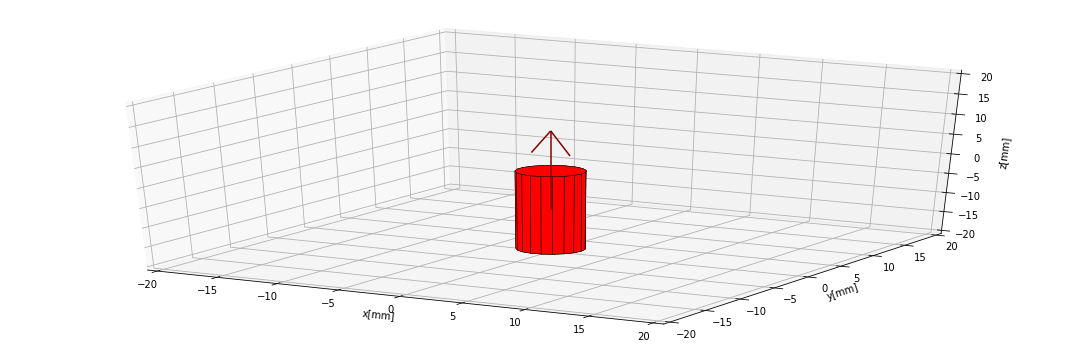

In [4]:
#@title setup_magnet_sample

# Sample Definition

demagnetizing_factor = 1/3             # sphere
volume = 4 / 3 * pi * (4 / 1000) ** 3  # V sphere r=4mm [m3]
M_saturation = 1.400e6                 # Ms Co room temperature [A/m]
sample = {'demagnetizing_factor': demagnetizing_factor, 'volume': volume, 'M_saturation': M_saturation}

# Magnet collection definition

m1 = Cylinder(mag=[0, 0, 1000], dim=[5, 20], pos=[0, 0, -10])
my_collection = Collection(m1)

display_collection = 1
if display_collection:
    fig = figure(num='System Display')
    ax = fig.add_subplot(projection='3d')
    displaySystem(my_collection, direc=True, markers=[(0, 0, 0)], suppress=False, subplotAx=ax)


/usr/local/lib/python3.6/dist-packages/magpylib/_lib/fields/PM_Cylinder.py:93: RuntimeWarning: Warning: getB Position directly on magnet surface
  warn('Warning: getB Position directly on magnet surface', RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/magpylib/_lib/fields/PM_Cylinder.py:93: RuntimeWarning: Warning: getB Position directly on magnet surface
  warn('Warning: getB Position directly on magnet surface', RuntimeWarning)


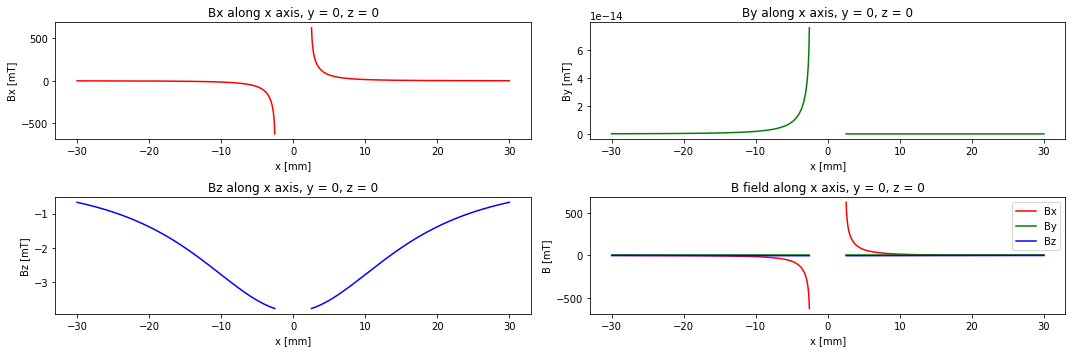

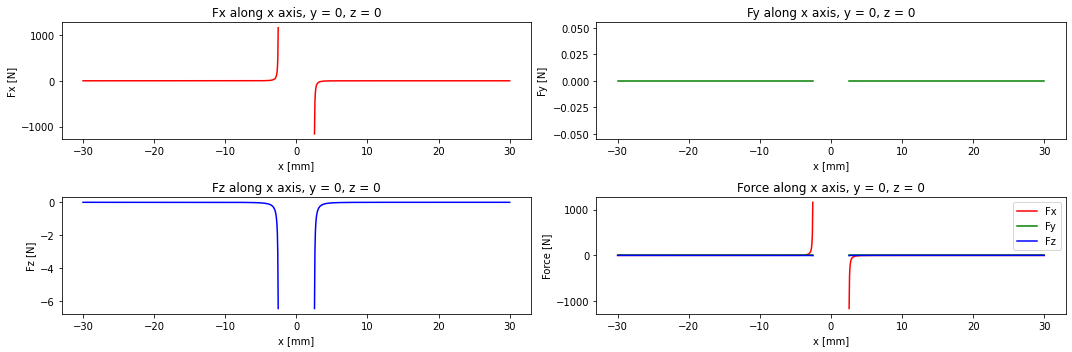

In [5]:
#@title simulation 1D along x

# simulation 1D along x
xs = linspace(-30, 30, 1000)
y, z = (0, 0)
plot_1D_along_x(xs, y, z, my_collection, sample=sample, BF='BF', saveCSV=False)

/usr/local/lib/python3.6/dist-packages/magpylib/_lib/fields/PM_Cylinder.py:93: RuntimeWarning: Warning: getB Position directly on magnet surface
  warn('Warning: getB Position directly on magnet surface', RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/magpylib/_lib/fields/PM_Cylinder.py:93: RuntimeWarning: Warning: getB Position directly on magnet surface
  warn('Warning: getB Position directly on magnet surface', RuntimeWarning)


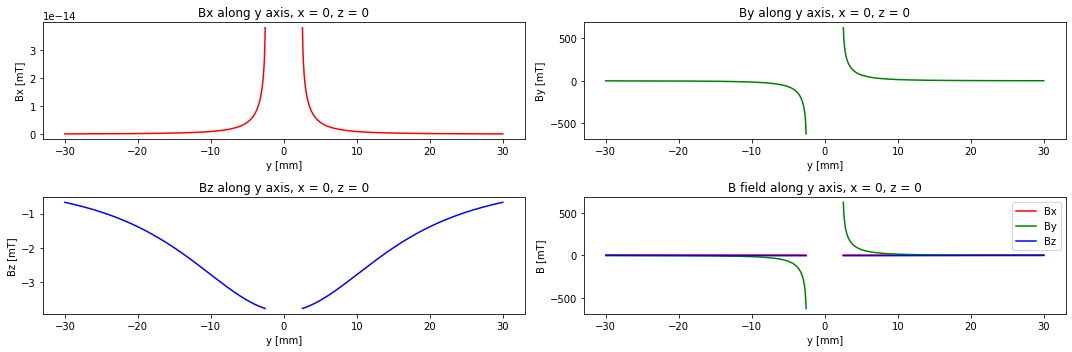

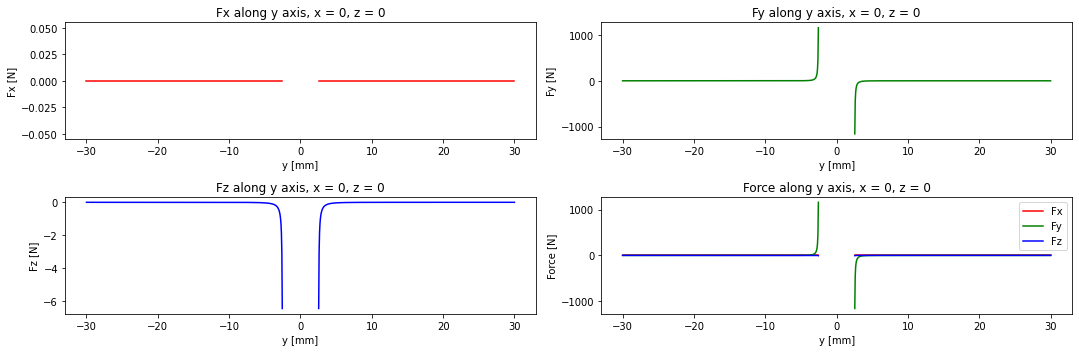

In [6]:
#@title simulation 1D along y
# simulation 1D along y

ys = linspace(-30, 30, 1000)
x, z = (0, 0)
plot_1D_along_y(x, ys, z, my_collection, sample=sample, BF='BF', saveCSV=False)

/usr/local/lib/python3.6/dist-packages/magpylib/_lib/fields/PM_Cylinder.py:93: RuntimeWarning: Warning: getB Position directly on magnet surface
  warn('Warning: getB Position directly on magnet surface', RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/magpylib/_lib/fields/PM_Cylinder.py:93: RuntimeWarning: Warning: getB Position directly on magnet surface
  warn('Warning: getB Position directly on magnet surface', RuntimeWarning)


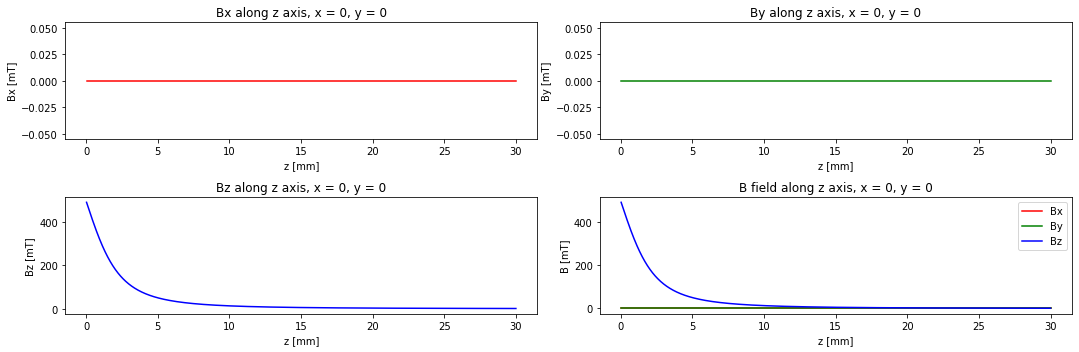

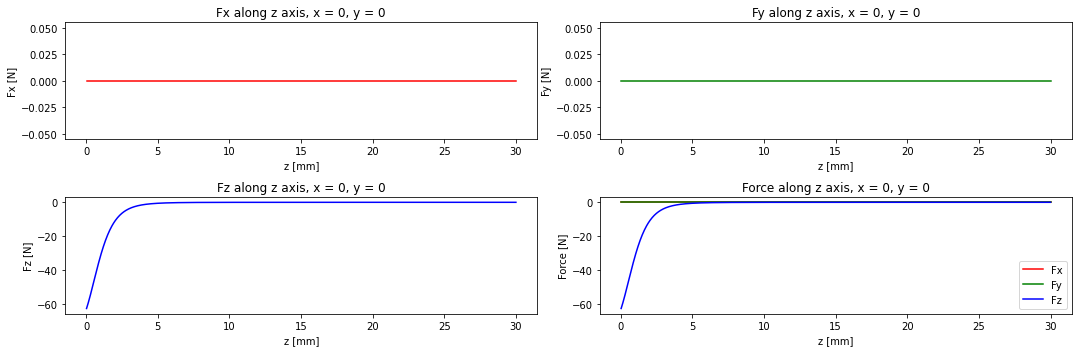

In [7]:
#@title simulation 1D along z
# simulation 1D along z

zs = linspace(0, 30, 1000)
y, z = (0, 0)
plot_1D_along_z(x, y, zs, my_collection, sample=sample, BF='BF', saveCSV=False)

/usr/local/lib/python3.6/dist-packages/magpylib/_lib/fields/PM_Cylinder.py:93: RuntimeWarning: Warning: getB Position directly on magnet surface
  warn('Warning: getB Position directly on magnet surface', RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:610: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:616: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:622: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:676: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:682: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:688: Use

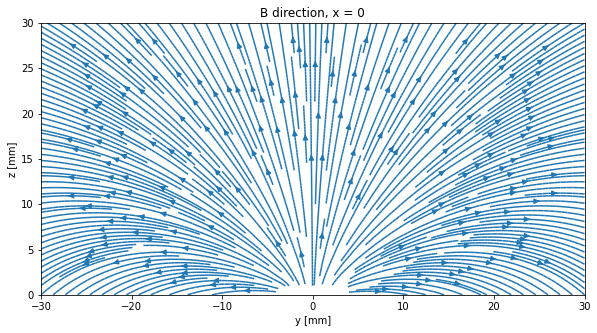

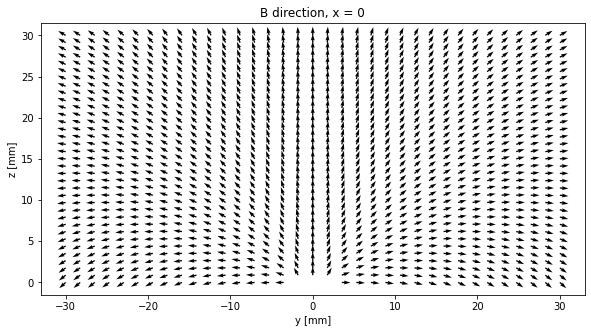

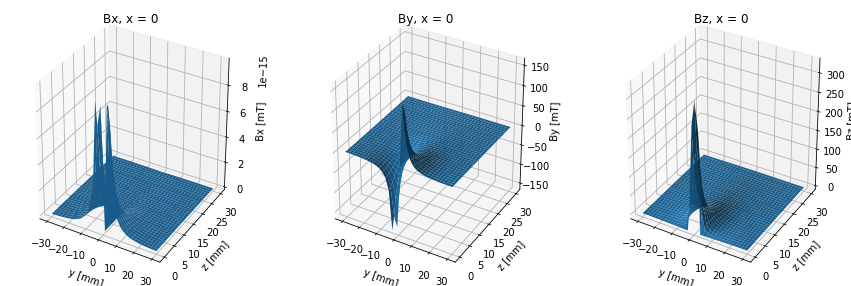

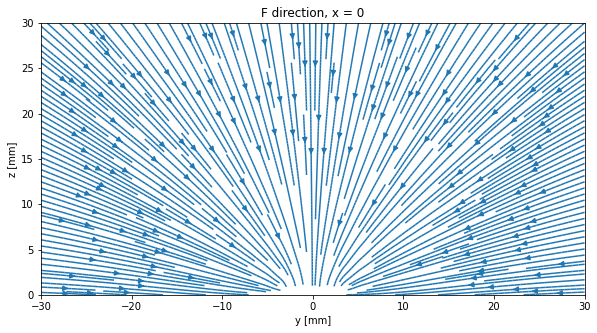

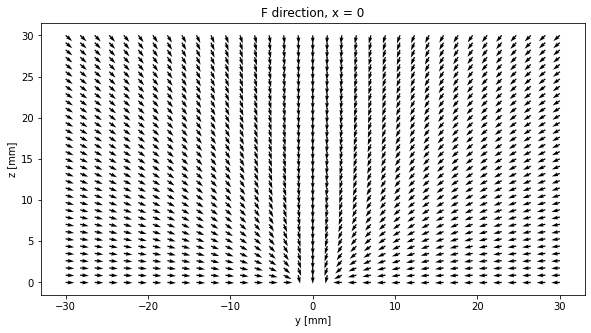

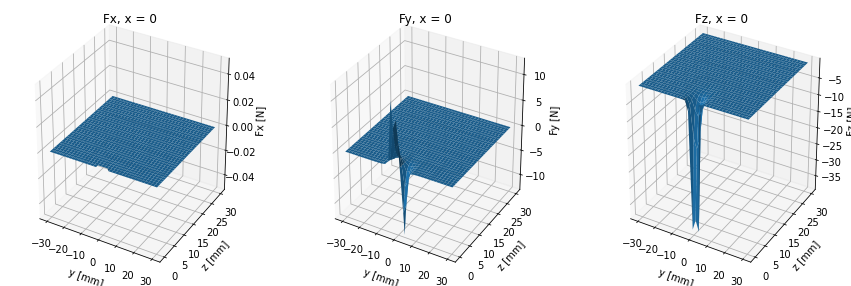

In [8]:
#@title simulation 2D on x plane
# simulation 2D on x plane

ys = linspace(-30, 30, 35)
zs = linspace(0, 30, 35)
x = 0
plot_2D_plane_x(x, ys, zs, my_collection, sample=sample, modes=['stream', 'quiver', 'surface'], BF='BF', saveCSV=False)


/usr/local/lib/python3.6/dist-packages/magpylib/_lib/fields/PM_Cylinder.py:93: RuntimeWarning: Warning: getB Position directly on magnet surface
  warn('Warning: getB Position directly on magnet surface', RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:833: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:839: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:845: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:899: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:905: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:911: Use

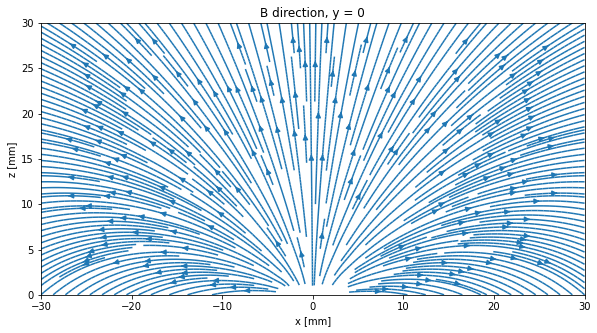

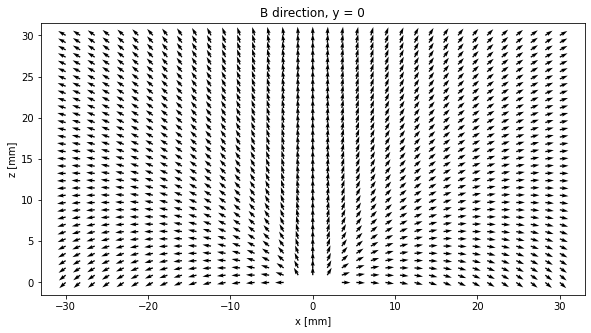

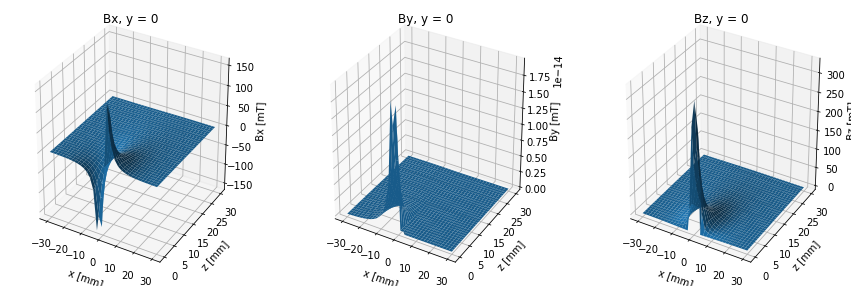

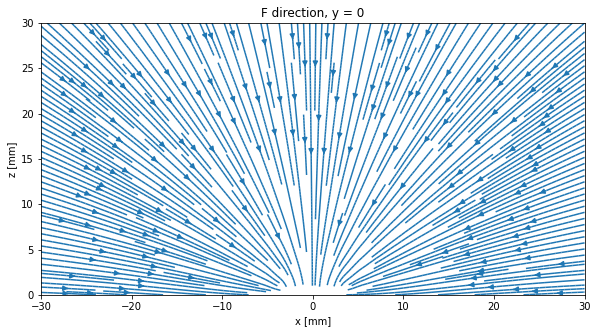

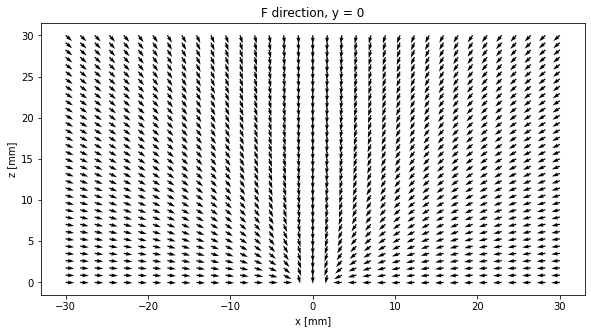

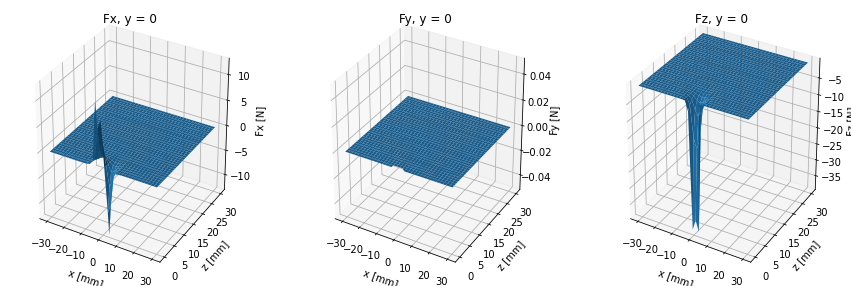

In [9]:
#@title simulation 2D on y plane
# simulation 2D on y plane

xs = linspace(-30, 30, 35)
zs = linspace(0, 30, 35)
y = 0
plot_2D_plane_y(xs, y, zs, my_collection, sample=sample, modes=['stream', 'quiver', 'surface'], BF='BF', saveCSV=False)


/usr/local/lib/python3.6/dist-packages/magpylib/_lib/fields/PM_Cylinder.py:93: RuntimeWarning: Warning: getB Position directly on magnet surface
  warn('Warning: getB Position directly on magnet surface', RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1056: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1062: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1068: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1122: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1128: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113

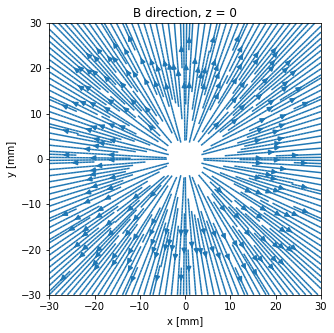

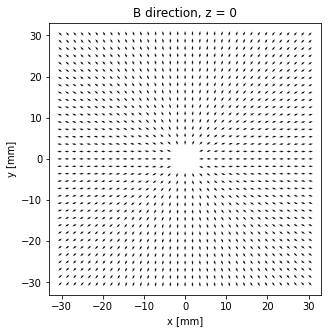

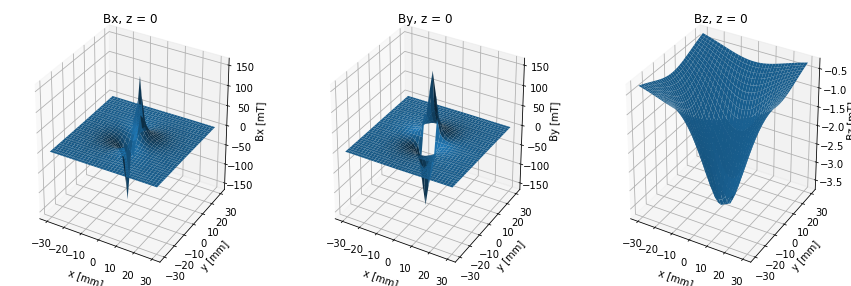

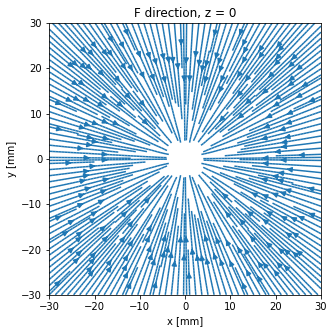

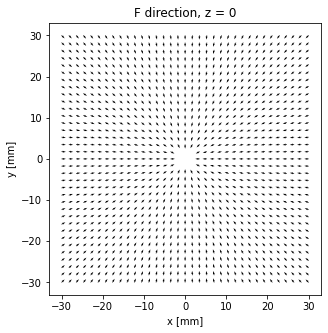

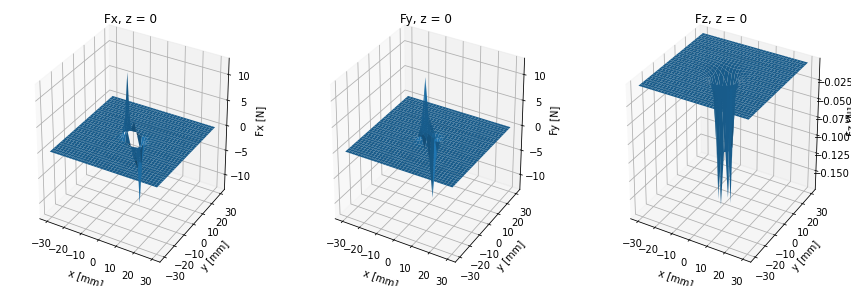

In [10]:
#@title simulation 2D on z plane
# simulation 2D on z plane

xs = linspace(-30, 30, 35)
ys = linspace(-30, 30, 35)
z = 0
plot_2D_plane_z(xs, ys, z, my_collection, sample=sample, modes=['stream', 'quiver', 'surface'], BF='BF', saveCSV=False)


/usr/local/lib/python3.6/dist-packages/magpylib/_lib/fields/PM_Cylinder.py:93: RuntimeWarning: Warning: getB Position directly on magnet surface
  warn('Warning: getB Position directly on magnet surface', RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/axes3d.py:2594: RuntimeWarning: invalid value encountered in greater
  mask = norm > 0


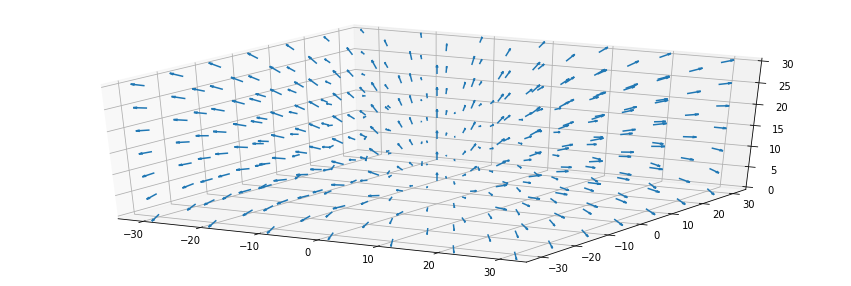

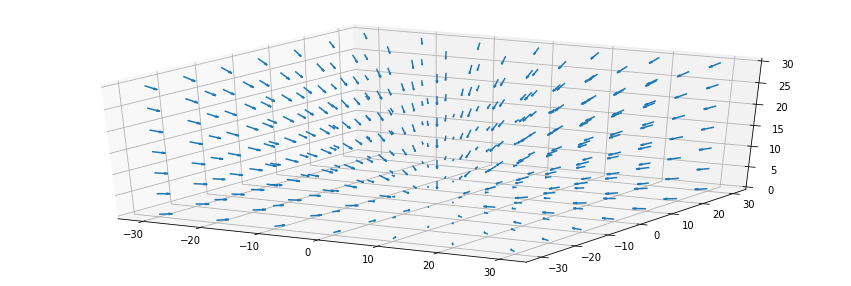

In [11]:
#@title simulation 3D
# simulation 3D

xs = linspace(-30, 30, 7)
ys = linspace(-30, 30, 7)
zs = linspace(0, 30, 7)

plot_3D(xs, ys, zs, my_collection, sample=sample, BF='BF', saveCSV=False)